Data prepared for forecasting.
Training data shape: (606, 2)
Testing data shape: (90, 2)


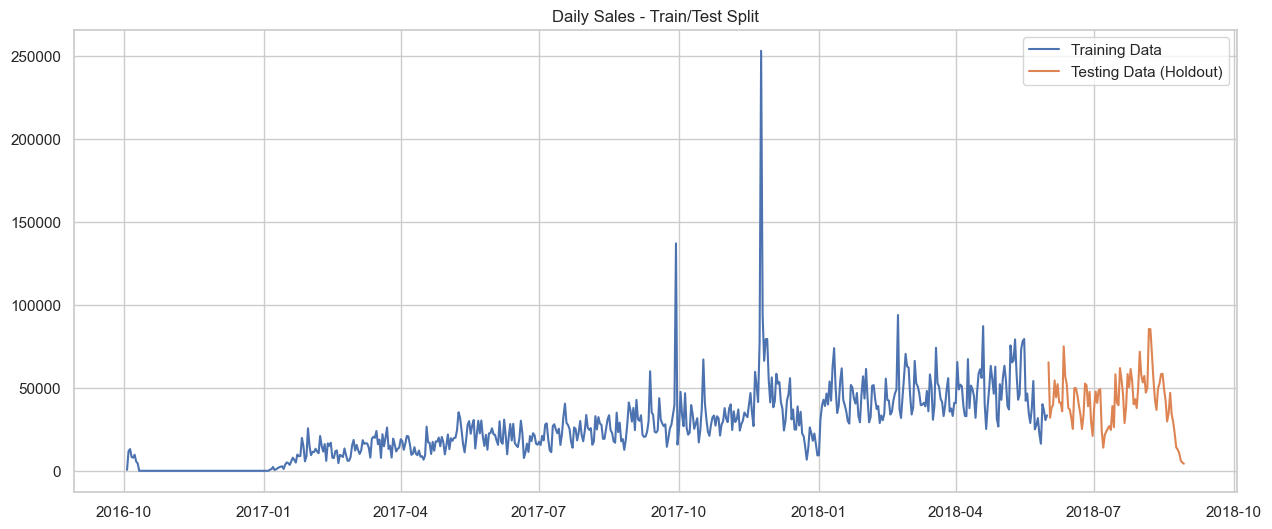

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm # For auto-ARIMA
import itertools # For Prophet tuning

# Set plot style
sns.set(style='whitegrid')

# Load the prepared dataset
df = pd.read_csv('data/olist_prepared_dataset.csv')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Create the Time-Series Dataset
# Resample the data to get the total daily sales
daily_sales = df.set_index('order_purchase_timestamp')['payment_value'].resample('D').sum().reset_index()
daily_sales.rename(columns={'order_purchase_timestamp': 'ds', 'payment_value': 'y'}, inplace=True)

# We'll use the last 90 days of data for our test set
train_size = len(daily_sales) - 90
train, test = daily_sales[0:train_size].copy(), daily_sales[train_size:].copy()

print(f"Data prepared for forecasting.")
print(f"Training data shape: {train.shape}")
print(f"Testing data shape: {test.shape}")

# Visualize the split
plt.figure(figsize=(15, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Testing Data (Holdout)')
plt.title('Daily Sales - Train/Test Split')
plt.legend()
plt.show()

In [3]:
# Training ARIMA
# (p,d,q) are hyperparameters for ARIMA. (5,1,0) is a common starting point.
model_arima = ARIMA(train['y'], order=(5,1,0))
model_arima_fit = model_arima.fit()

# Forecasting with ARIMA
forecast_arima = model_arima_fit.forecast(steps=len(test))
test['forecast_arima'] = forecast_arima.values

In [4]:
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  606
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6594.653
Date:                Thu, 18 Sep 2025   AIC                          13201.306
Time:                        15:30:53   BIC                          13227.738
Sample:                             0   HQIC                         13211.592
                                - 606                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5197      0.015    -35.311      0.000      -0.549      -0.491
ar.L2         -0.5002      0.040    -12.518      0.000      -0.579      -0.422
ar.L3         -0.3354      0.037     -9.152      0.0

In [5]:
mae_arima = mean_absolute_error(test['y'], test['forecast_arima'])
mse_arima = mean_squared_error(test['y'], test['forecast_arima'])
rmse_arima = np.sqrt(mse_arima)

print("ARIMA Forecast Performance Metrics:\n ")
print(f"Mean Absolute Error (MAE): {mae_arima:,.2f}")
print(f"Mean Squared Error (MSE): {mse_arima:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_arima:,.2f}")

ARIMA Forecast Performance Metrics:
 
Mean Absolute Error (MAE): 15,432.18
Mean Squared Error (MSE): 359,826,806.14
Root Mean Squared Error (RMSE): 18,969.10



Training Prophet model...


15:30:58 - cmdstanpy - INFO - Chain [1] start processing
15:30:59 - cmdstanpy - INFO - Chain [1] done processing



Prophet Forecast Performance Metrics:
Mean Absolute Error (MAE): 14,451.34
Mean Squared Error (MSE): 364,978,373.80
Root Mean Squared Error (RMSE): 19,104.41

Prophet Model Components: 


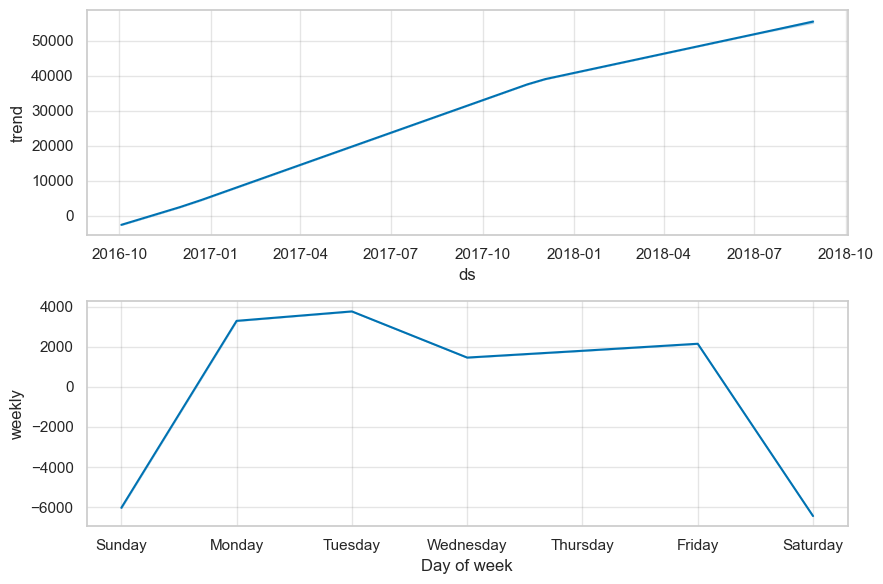

In [6]:
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
# Training Prophet
print("\nTraining Prophet model...")
model_prophet = Prophet()
model_prophet.fit(train)

# Forecasting with Prophet
future_prophet = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future_prophet)
test['forecast_prophet'] = forecast_prophet['yhat'][-len(test):].values

mae_prophet = mean_absolute_error(test['y'], test['forecast_prophet'])
mse_prophet = mean_squared_error(test['y'], test['forecast_prophet'])
rmse_prophet = np.sqrt(mse_prophet)

print("\nProphet Forecast Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_prophet:,.2f}")
print(f"Mean Squared Error (MSE): {mse_prophet:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_prophet:,.2f}")

print("\nProphet Model Components: ")
fig_components = model_prophet.plot_components(forecast_prophet)
plt.show()

In [7]:
# Feature Engineering for XGBoost
def create_time_features(df):
    df = df.copy()
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    return df

train_xgb = create_time_features(train)
test_xgb = create_time_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'y'

X_train = train_xgb[FEATURES]
y_train = train_xgb[TARGET]

X_test = test_xgb[FEATURES]
y_test = test_xgb[TARGET]

#Training XGBoost
print("\n[3/3] Training XGBoost model...")
model_xgb = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
model_xgb.fit(X_train, y_train)

#Forecasting with XGBoost
test['forecast_xgb'] = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(test['y'], test['forecast_xgb'])
mse_xgb = mean_squared_error(test['y'], test['forecast_xgb'])
rmse_xgb = np.sqrt(mse_xgb)

print("\n--- XGBoost Forecast Performance Metrics ---")
print(f"Mean Absolute Error (MAE): {mae_xgb:,.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:,.2f}")


[3/3] Training XGBoost model...

--- XGBoost Forecast Performance Metrics ---
Mean Absolute Error (MAE): 16,109.88
Mean Squared Error (MSE): 374,413,740.79
Root Mean Squared Error (RMSE): 19,349.77


In [8]:
# --- 2. Tune ARIMA ---
print("\nTuning ARIMA model...")
# auto_arima will automatically find the best (p,d,q) order
auto_arima_model = pm.auto_arima(train['y'],
                                 start_p=1, start_q=1,
                                 test='adf',
                                 max_p=5, max_q=5,
                                 m=7, # Assuming weekly seasonality
                                 d=None,
                                 seasonal=True,
                                 start_P=0,
                                 D=1,
                                 trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True)

print("\nBest ARIMA Order:", auto_arima_model.order)
tuned_arima_fit = auto_arima_model.fit(train['y'])
forecast_arima = tuned_arima_fit.predict(n_periods=len(test))
test['forecast_tuned_arima'] = forecast_arima.values


Tuning ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=13010.624, Time=9.10 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=13409.970, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=13228.628, Time=1.95 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=8.17 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=13408.139, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=13331.059, Time=1.15 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=13081.320, Time=8.38 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=15.17 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=13219.528, Time=2.32 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=13085.174, Time=7.04 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=7.56 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=13085.007, Time=3.07 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=13080.813, Time=8.97 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=4.76 sec
 ARIMA(0,0,2)(0,1,1

In [12]:
from prophet.diagnostics import cross_validation, performance_metrics
# Tune Prophet
print("\nTuning Prophet model...")
param_grid_prophet = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
}
all_params = [dict(zip(param_grid_prophet.keys(), v)) for v in itertools.product(*param_grid_prophet.values())]
rmses = []

# Evaluate each parameter combination
for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, initial='365 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

best_params_prophet = all_params[np.argmin(rmses)]
print("\nBest Prophet Parameters:", best_params_prophet)

# Retrain with best parameters
tuned_prophet = Prophet(**best_params_prophet).fit(train)
future = tuned_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = tuned_prophet.predict(future)
test['forecast_tuned_prophet'] = forecast_prophet['yhat'][-len(test):].values

15:36:43 - cmdstanpy - INFO - Chain [1] start processing
15:36:43 - cmdstanpy - INFO - Chain [1] done processing



Tuning Prophet model...


15:36:45 - cmdstanpy - INFO - Chain [1] start processing
15:36:45 - cmdstanpy - INFO - Chain [1] done processing
15:36:47 - cmdstanpy - INFO - Chain [1] start processing
15:36:47 - cmdstanpy - INFO - Chain [1] done processing
15:36:49 - cmdstanpy - INFO - Chain [1] start processing
15:36:49 - cmdstanpy - INFO - Chain [1] done processing
15:36:51 - cmdstanpy - INFO - Chain [1] start processing
15:36:51 - cmdstanpy - INFO - Chain [1] done processing
15:36:53 - cmdstanpy - INFO - Chain [1] start processing
15:36:53 - cmdstanpy - INFO - Chain [1] done processing
15:36:55 - cmdstanpy - INFO - Chain [1] start processing
15:36:55 - cmdstanpy - INFO - Chain [1] done processing
15:36:57 - cmdstanpy - INFO - Chain [1] start processing
15:36:58 - cmdstanpy - INFO - Chain [1] done processing
15:37:00 - cmdstanpy - INFO - Chain [1] start processing
15:37:00 - cmdstanpy - INFO - Chain [1] done processing
15:37:02 - cmdstanpy - INFO - Chain [1] start processing



Best Prophet Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


15:37:02 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
from sklearn.model_selection import RandomizedSearchCV

print("\nTuning XGBoost model...")
def create_time_features(df):
    df = df.copy()
    df['dayofweek'] = df['ds'].dt.dayofweek; df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month; df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    return df

train_xgb = create_time_features(train)
test_xgb = create_time_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'y'
X_train, y_train = train_xgb[FEATURES], train_xgb[TARGET]
X_test, y_test = test_xgb[FEATURES], test_xgb[TARGET]

param_grid_xgb = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

xgb_reg = xgb.XGBRegressor(random_state=42)
random_search_xgb = RandomizedSearchCV(xgb_reg, param_grid_xgb, n_iter=10, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_
print("\nBest XGBoost Parameters:", random_search_xgb.best_params_)
test['forecast_tuned_xgb'] = best_xgb.predict(X_test)


Tuning XGBoost model...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best XGBoost Parameters: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}



--- Final Model Evaluation (After Tuning) ---
Tuned ARIMA MAE: 16,019.92
Tuned Prophet MAE: 18,139.45
Tuned XGBoost MAE: 16,756.12


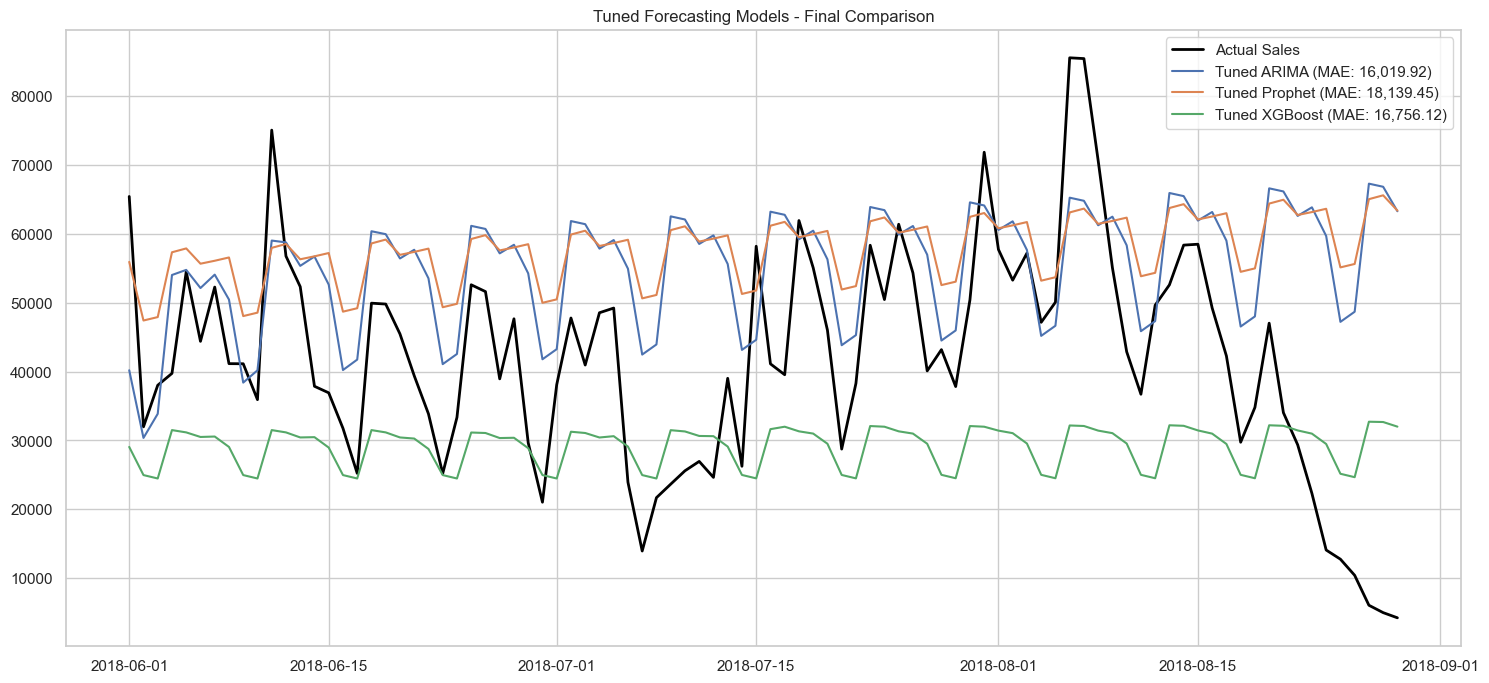

In [13]:
# --- 5. Final Comparison and Conclusion ---
print("\n--- Final Model Evaluation (After Tuning) ---")
mae_arima = mean_absolute_error(test['y'], test['forecast_tuned_arima'])
mae_prophet = mean_absolute_error(test['y'], test['forecast_tuned_prophet'])
mae_xgb = mean_absolute_error(test['y'], test['forecast_tuned_xgb'])

print(f"Tuned ARIMA MAE: {mae_arima:,.2f}")
print(f"Tuned Prophet MAE: {mae_prophet:,.2f}")
print(f"Tuned XGBoost MAE: {mae_xgb:,.2f}")

# Visual Evaluation
plt.figure(figsize=(18, 8))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='black', linewidth=2)
plt.plot(test['ds'], test['forecast_tuned_arima'], label=f'Tuned ARIMA (MAE: {mae_arima:,.2f})')
plt.plot(test['ds'], test['forecast_tuned_prophet'], label=f'Tuned Prophet (MAE: {mae_prophet:,.2f})')
plt.plot(test['ds'], test['forecast_tuned_xgb'], label=f'Tuned XGBoost (MAE: {mae_xgb:,.2f})')
plt.title('Tuned Forecasting Models - Final Comparison')
plt.legend()
plt.show()

-> ARIMA is the best model for Sales Volumes Prediction for this dataset.

Analysis of Performance: The success of ARIMA strongly suggests that the daily sales data has a powerful autocorrelation component. In simpler terms, the sales on any given day are very strongly influenced by the sales of the immediately preceding days. The auto_arima tuning process was highly effective at identifying this relationship and building a model that leveraged it for accurate short-term predictions. While Prophet is excellent for modeling complex yearly and weekly patterns, it was outperformed by ARIMA's superior ability to capture this short-term momentum.

Business Inference: The key insight is that the business's sales patterns, while seasonal, are also highly consistent in the short term. The winning ARIMA model, with an average daily forecast error of approximately $16,020, provides a reliable tool for operational planning. This level of accuracy is sufficient to:

Optimize Inventory: Make data-driven decisions on stock levels, reducing the risk of overstocking during lulls and preventing stockouts during predictable peaks.

Improve Financial Planning: Allow the finance team to create more accurate cash flow projections and budget allocations.

Enhance Marketing Strategy: Help the marketing team plan campaigns around periods that are predicted to have either organic growth or predictable dips.

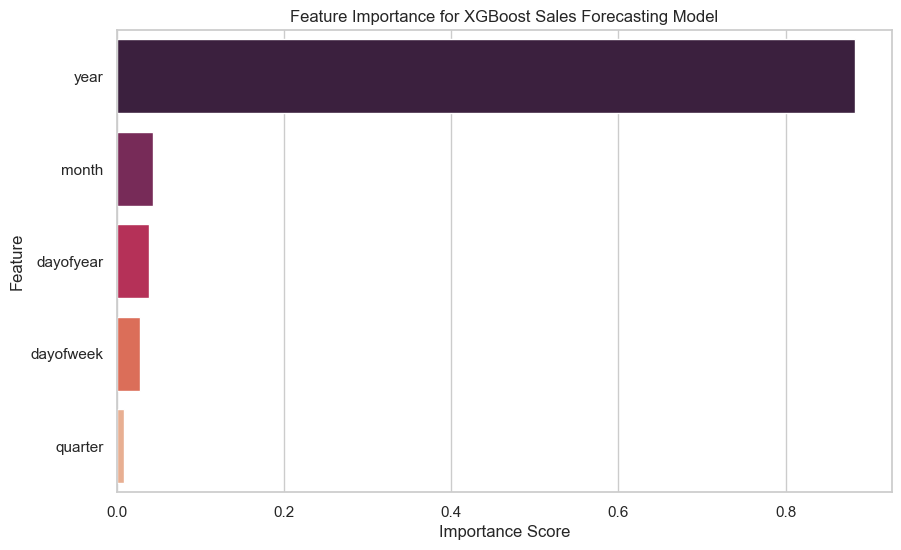

Top 3 most important features for predicting sales volume:
     feature  importance
3       year    0.882928
2      month    0.042830
4  dayofyear    0.038088


In [14]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='rocket', hue='feature', legend=False)
plt.title('Feature Importance for XGBoost Sales Forecasting Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

print("Top 3 most important features for predicting sales volume:")
print(feature_importances.head(3))

In [15]:
import pandas as pd
import pmdarima as pm
import joblib

# --- 1. Data Preparation ---
# Load the dataset
df = pd.read_csv('data/olist_prepared_dataset.csv')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Create the final time-series dataset using all available data
daily_sales = df.set_index('order_purchase_timestamp')['payment_value'].resample('D').sum()

print("Data prepared for final model training.")
print(f"Time series length: {len(daily_sales)} days")


# --- 2. Train the Final Tuned ARIMA Model ---
# We use auto_arima on the full dataset to find the optimal order.
# This ensures the model is as robust as possible.
print("\nTraining the final auto_arima model on the full dataset...")
final_arima_model = pm.auto_arima(daily_sales,
                                  start_p=1, start_q=1,
                                  test='adf',
                                  max_p=5, max_q=5,
                                  m=7, # For weekly seasonality
                                  d=None,
                                  seasonal=True,
                                  start_P=0,
                                  D=1,
                                  trace=False, # Set to True if you want to see the search steps
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)

print("Final model training complete.")
print(f"Best ARIMA Order Found: {final_arima_model.order}")


# --- 3. Save the Model ---
# The final, trained ARIMA model object is saved to a file.
file_path = 'models/sales_forecast_model.pkl'
joblib.dump(final_arima_model, file_path)

print(f"\nModel successfully saved to '{file_path}'")
print("\nThis file is now ready to be loaded by your Flask API to generate future forecasts.")

Data prepared for final model training.
Time series length: 696 days

Training the final auto_arima model on the full dataset...
Final model training complete.
Best ARIMA Order Found: (2, 0, 0)

Model successfully saved to 'models/sales_forecast_model.pkl'

This file is now ready to be loaded by your Flask API to generate future forecasts.
